In [ ]:
import numpy as np
import pandas as pd

In [3]:
train_fname = './datasets/reviews.tsv'
df_train = pd.read_csv(train_fname, sep='\t')
df_train.head()

,sentiment,review
0,0,"For all the magic, all the tricks, and all the..."
1,2,"If the first is a landmark gangster epic, then..."
2,2,Disney and Pixar studios team up and brought u...
3,2,Some scenes in this movie are now considered t...
4,0,"Maybe it's a generational thing, or I simply j..."


In [4]:
df_train['sentiment'].value_counts()

sentiment
1    10884
2     9932
0     9429
Name: count, dtype: int64

Text(0.5, 0, 'Sentiment')

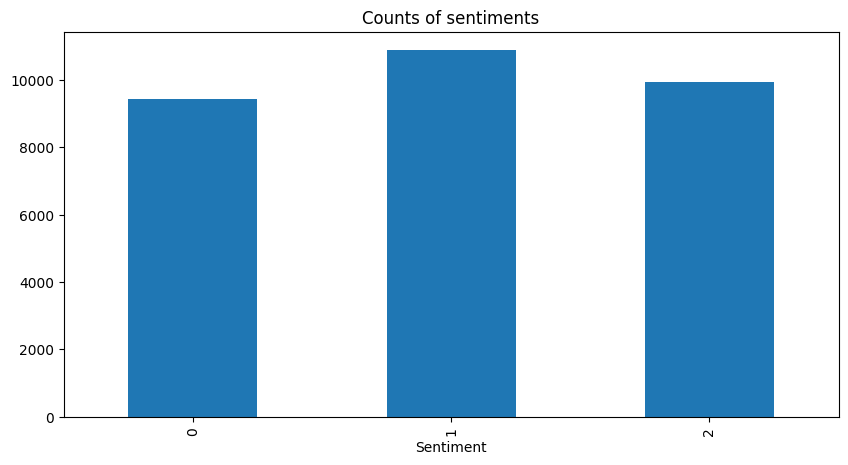

In [5]:
ax = df_train['sentiment'].value_counts().sort_index().plot(kind='bar', title='Counts of sentiments', figsize=(10, 5))
ax.set_xlabel('Sentiment')

In [65]:
import re
import nltk
import spacy
import spacy.cli

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [66]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [73]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = word_tokenize(text)

    filtered_words = [word for word in words if not word in stop_words]
    lemmas = []
    for word in filtered_words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    sentence = ' '.join(lemmas)
    doc = nlp(sentence)
    lemmas = [token.lemma_ for token in doc]

    return lemmas

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df_train['words'] = df_train['review'].progress_apply(clean_text)

In [8]:
from collections import Counter

def get_corpus(df):
    corpus = []
    for i in tqdm(range(len(df))):
        corpus.append(df['words'].values[i])
    corpus = Counter(np.hstack(corpus))
    corpus2 = sorted(corpus, key=corpus.get, reverse=True)
    corpus2 = ['<PAD>', '<UNK>'] + corpus2
    vocab = {word: idx for idx, word in enumerate(corpus2, 1)}
    return corpus, vocab

In [9]:
corpus, vocab = get_corpus(df_train)

100%|██████████| 30245/30245 [00:00<00:00, 42245.74it/s]


In [ ]:
import pickle

with open('./vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [13]:
def phrase_to_ints(words):
    ints = [vocab.get(word, vocab['<UNK>']) for word in words]
    return ints

In [15]:
df_train['ints'] = df_train['words'].progress_apply(phrase_to_ints)

100%|██████████| 30245/30245 [00:01<00:00, 22923.82it/s]


In [17]:
review_to_ints = []
for i in tqdm(range(len(df_train))):
    review_to_ints.append(df_train['ints'].values[i])

100%|██████████| 30245/30245 [00:00<00:00, 123202.66it/s]


In [18]:
def pad_sequences(phrase_to_int, seq_length):
    if not isinstance(phrase_to_int[0], list):
        phrase_to_int = [phrase_to_int]
    pad_sequences = np.zeros((len(phrase_to_int), seq_length), dtype=int)
    for idx,row in tqdm(enumerate(phrase_to_int), total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

In [19]:
seq_length = 300
padded_sequences = pad_sequences(review_to_ints, seq_length)

100%|██████████| 30245/30245 [00:00<00:00, 74562.35it/s]


In [21]:
labels = df_train['sentiment'].tolist()

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [24]:
import torch

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_test)
y_val_tensor = torch.tensor(y_test)

In [55]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 60

train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [56]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size())
print('Sample label size: ', sample_y.size())
print('Sample input: \n', sample_x)

print("\nData loader size: {} (train), {} (val)".format(len(train_loader), len(valid_loader)))

Sample input size:  torch.Size([60, 300])
Sample label size:  torch.Size([60])
Sample input: 
 tensor([[   10,    25,   753,  ...,     0,     0,     0],
        [   39,  2528,  5476,  ...,     0,     0,     0],
        [   86, 31907,   771,  ...,     0,     0,     0],
        ...,
        [  693,   124,   725,  ...,     0,     0,     0],
        [   14,   110,   361,  ...,     0,     0,     0],
        [  644, 10678,    12,  ...,     0,     0,     0]])

Data loader size: 403 (train), 100 (val)


In [57]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [97]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_last_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_last_out)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        return hidden


In [98]:
n_vocab = len(vocab) + 1
n_embed = 300
n_hidden = 256
n_output = 3
n_layers = 2
learning_rate = 0.001

In [87]:
net = SentimentRNN(n_vocab, n_output, n_embed, n_hidden, n_layers)
print(net)

SentimentRNN(
  (embedding): Embedding(46869, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%d%m%y")
model_name = "./model_{}.pth".format(current_time)
print(model_name)

./model_220424.pth


In [101]:
n_epochs = 5
eval_every = 100
clip = 5
min_val_loss = float('inf')

train_losses = []
valid_losses = []

net.to(device)
net.train()

SentimentRNN(
  (embedding): Embedding(46869, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [102]:
for e in range(n_epochs):
    counter = 0
    epoch_train_losses = []
    
    h = net.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        train_loss = loss.item()
        epoch_train_losses.append(train_loss)

        if counter % eval_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            val_accuracies = []
            
            net.eval()
            
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            mean_val_loss = np.mean(val_losses)
            
            net.train()
            
            print("Epoch: {}/{},".format(e+1, n_epochs),
                  "Step: {},".format(counter),
                  "Loss: {:.6f},".format(loss.item()),
                  "Val loss: {:.6f}".format(mean_val_loss))

    valid_losses.append(mean_val_loss)
    print("Val loss after epoch {}: {:.6f}".format(e+1, mean_val_loss))
    
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)
    
    if mean_val_loss < min_val_loss:
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model...".format(min_val_loss, mean_val_loss))
        min_val_loss = mean_val_loss
        torch.save(net.state_dict(), model_name)

Epoch: 1/5, Step: 100, Loss: 1.100657, Val loss: 1.099362
Epoch: 1/5, Step: 200, Loss: 1.066599, Val loss: 1.096794
Epoch: 1/5, Step: 300, Loss: 1.061413, Val loss: 1.080662
Epoch: 1/5, Step: 400, Loss: 1.071623, Val loss: 1.065853
Val loss after epoch 1: 1.065853
Validation loss decreased (inf --> 1.065853). Saving model...
Epoch: 2/5, Step: 100, Loss: 1.049375, Val loss: 1.111616
Epoch: 2/5, Step: 200, Loss: 0.951395, Val loss: 1.047277
Epoch: 2/5, Step: 300, Loss: 0.950551, Val loss: 1.037416
Epoch: 2/5, Step: 400, Loss: 0.940587, Val loss: 1.015169
Val loss after epoch 2: 1.015169
Validation loss decreased (1.065853 --> 1.015169). Saving model...
Epoch: 3/5, Step: 100, Loss: 1.032867, Val loss: 1.027296
Epoch: 3/5, Step: 200, Loss: 0.900137, Val loss: 1.026246
Epoch: 3/5, Step: 300, Loss: 0.996163, Val loss: 1.020880
Epoch: 3/5, Step: 400, Loss: 0.943375, Val loss: 1.003266
Val loss after epoch 3: 1.003266
Validation loss decreased (1.015169 --> 1.003266). Saving model...
Epoch: 4/

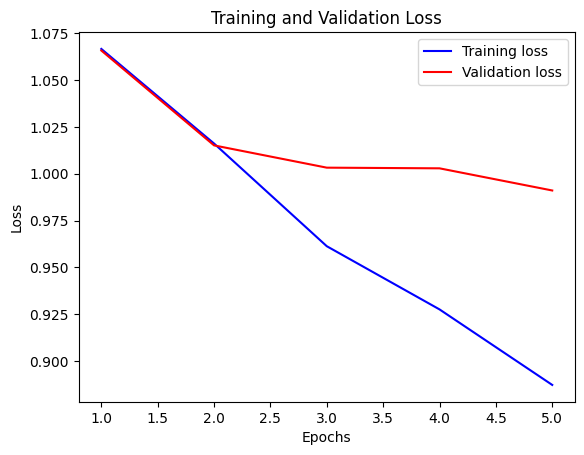

In [103]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
def predict(model, sentence):
    words = clean_text(sentence)
    text_ints = phrase_to_ints(words)
    padded_text = pad_sequences(text_ints, seq_length)
    
    text_tensor = torch.from_numpy(padded_text)
    text_tensor = text_tensor.to(device)
    
    model.eval()
    
    batch_size = text_tensor.size(0)
    h = model.init_hidden(batch_size)
    
    output, _ = model(text_tensor, h)
    predicted = output.flatten().cpu().detach().numpy()
    label = np.argmax(predicted)
    
    return predicted, label

In [106]:
sentence = "Not good but not terrible either"
predicted, label = predict(net, sentence)
print(predicted)
print(label)

100%|██████████| 1/1 [00:00<00:00, 6700.17it/s]

[0.29532787 0.69346505 0.01120711]
1
